In [6]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as geopd
import sklearn.cluster as clustering
import scipy.stats as stats
import numpy as np
os.chdir("/Users/simonedigregorio/Downloads/archive")

# Homework 2 from Group 30

## Index
- #### [RQ1](#rq1)
    - [posts dataset](#rq1.1)
    - [profiles dataset](#rq1.2)
    - [locations dataset](#rq1.3)
- #### [RQ2](#rq2)
- #### [RQ3](##RQ3)
- #### [RQ4](##RQ4)
- #### [RQ5](##RQ5)
- #### [RQ6](##RQ6)
- #### [RQ6](##RQ6)

## RQ1
<a id = "rq1"></a>


For the first research question we are asked to do some general **exploratory data analysis** concerning the dataset we are given to work on the homework.

We will examine the three different _csv_ tables one by one, describing which kind of features they contain, showing some descriptive statistics and visualizing some distributions and patterns.

Before continuing, we read the datasets.

In [7]:
# Read the datasets
# Also converting the column cts in posters to date/time type. This will be useful for later stages
posts = pd.read_csv("instagram_posts.csv", delimiter="\t", parse_dates=[5], infer_datetime_format = True)
profiles = pd.read_csv("instagram_profiles.csv", delimiter="\t")
locations = pd.read_csv("instagram_locations.csv", delimiter="\t")

Let's start with a **very** basic summary of the features of the datasets. On a very coarse level of analysis, we can check the number of observations in each dataset. _Posts_ is definitely the biggest one, with 42'710'197 observations, followed by _profiles_ (with 4'509'586 observations) and _locations_ (with 1'022'658 observations).

Relatively speaking, this makes sense considering that for every profile there will be $n$ posts and considering that locations get repeated a lot among posts, with many posts not even having any location. Specifically, to give an idea, locations repeat on average 17 times in the _post_ dataset and there are 12'972'772 posts without locations as can be seen in the code (this partially answers a point of [RQ2](#RQ2)).

However, there are some inconsistencies in the tables (posts from profiles not present in the _profile_ dataset or posts with tagged locations not present in the _locations_ dataset), so what we are saying here is only meant to give an idea.

In [8]:
# Number of observations for dataset
print(f"Number of obs posts:{len(posts)}")
print(f"Number of obs profiles: {len(profiles)}")
print(f"Number of obs locations: {len(locations)}")

# Number of non-complete observations for dataset
# Is null returns a dataframe of booleans (na or not for each entry). Any returns true for each row (axis=1) which has a true value (a na field) and sums over the booleans, considering False as 0 and True as 1. This is a solution which is more elegant with respect to others.
print(f"Number of non-complete rows in posts: {posts.isnull().any(axis=1).sum()}")
print(f"Number of non-complete rows in profiles: {profiles.isnull().any(axis=1).sum()}")
print(f"Number of non-complete rows in locations: {locations.isnull().any(axis=1).sum()}")

# Number of posts without locations
print("Number of posts without locations: {}".format(posts["location_id"].isnull().sum()))
# Mean number of posts for each location (2 decimal digits)
print("Mean number of repetitions for each location: {}".format(round(posts["location_id"].value_counts().mean())))

Number of obs posts:42710197
Number of obs profiles: 4509586
Number of obs locations: 1022658
Number of non-complete rows in posts: 16280069
Number of non-complete rows in profiles: 3763522
Number of non-complete rows in locations: 1022658
Number of posts without locations: 12972772
Mean number of repetitions for each location: 17


### Features of the _posts_ dataset
<a id = "rq1.1"></a>


  First step in any proper EDA is looking at the columns of the tables that we are using. Luckily the guy who uploaded the dataset on Kaggle was also very clear in describing the features. Let's start with the _posts_ dataset, the first and most important one:
  - The _sid_profile_ feature acts as something similar to a foreign key to link the _posts_ dataset to the _profiles_ dataset, allowing joins. -1 is the id for profiles not present in the _profiles_ dataset.
  - The post_id is the ID of the post itself, nothing particularly important to say: it is just a key of the table.
  - The _profile_id_ is the instagram ID of the profile which published the post.
  - The _location_id_ is the foreign key that links the _posts_ dataset to the _location_ one.
  - _cts_ is the timestamp of the post.
  - _post_type_ is a categorical variable/a factor with three levels (1, 2, 3), which tell us if the post was a photo, a video or multimedia.
  - _numbr_likes_ is the number of likes.
  - _number_comments_ is the number of comments.

In [9]:
posts.columns.values

array(['sid', 'sid_profile', 'post_id', 'profile_id', 'location_id',
       'cts', 'post_type', 'description', 'numbr_likes',
       'number_comments'], dtype=object)

  The only numerical variables for the _posts_ dataset are the number of likes and the number of comments. We print the basic summary statistics (mean, standard deviation, maximum, minimum and quartiles) for these variables in markdown format in order to put them into the notebook. From the table, we can already notice some important features of the distribution. For example, the variances are **very** high and the quartiles are all lower than the mean values. This specific last information tells us that the distribution is strongly right-tailed.

More specifically, we can check that numerically (and statistically) by computing the skewness and the kurtosis (third and four standardized moment of the sample distribution). The skewness is in both cases **strongly** positive (very strong right tail indeed), which tells us that the mass is concentrated on the far left of the distro. This would be enough, but in order to make it more clear notice also the excess kurtosis (w.r.t. to the normal).

<a id = "graph_theory_pref"></a>These are **extremely** distorted distributions (the one for comments far more distorted than the one for likes), which makes sense since in a social network environment we expect the directed graph of connections/interactions to follow some kind of **preferential attachment** process.

In [77]:
# Print the basic summary statistics for the numeric variables
# Line not executed because it is added directly to the notebook as a markdown table.
# print(posts.describe().iloc[1:, 5:].to_markdown(), end = "\n\n")

# Print the skewness and the kurtosis for likes and comments
print("Skewness for likes distro: {}\nSkewness for comments distro: {}".format(round(posts["numbr_likes"].skew(), 2), round(posts["number_comments"].skew(), 2)))
print("Excess kurtosis for likes distro: {}\nExcess kurtosis for comments distro: {}".format(round(posts["numbr_likes"].kurtosis(), 2), round(posts["number_comments"].kurtosis(), 2)))

Skewness for likes distro: 277.16
Skewness for comments distro: 874.7
Excess kurtosis for likes distro: 189415.37
Excess kurtosis for comments distro: 1418528.53


|      |    numbr_likes |   number_comments |
|:-----|---------------:|------------------:|
| mean |  283.503       |           7.59531 |
| std  | 6124.61        |         194.148   |
| min  |    0           |           0       |
| 25%  |   20           |           0       |
| 50%  |   46           |           2       |
| 75%  |  114           |           5       |
| max  |    8.82295e+06 |      488953       |

 A way to visualize distributions so distorted would be to simply avoid considering the outliers and concentrate on the quartiles of the distribution. This can be done by plotting the boxplots considering just the quartiles and the whiskers (the right whisker is the 3rd quartile + 1.5 IQR) and avoiding the outliers.

`showfliers = False` in the Pandas utility method (which in turn calls _matplotlib_) is enough to make the plot readable. As can be seen in the table, look at how low is the value of the points in the interquartile range.

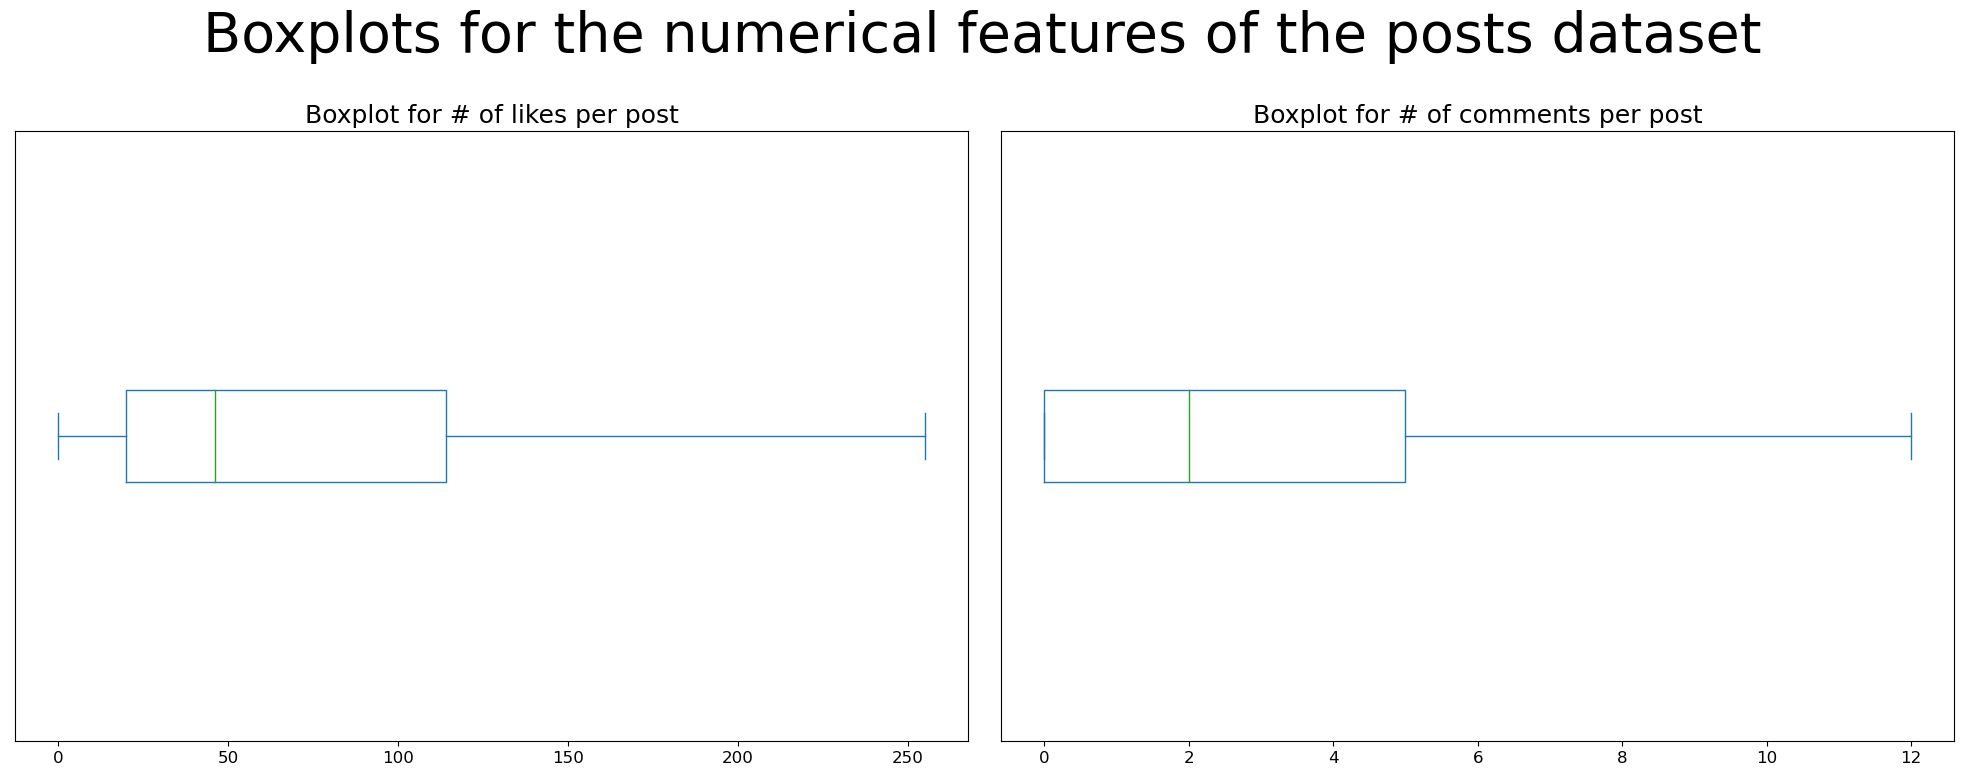

In [13]:
# Boxplot numerical of posts
plt.figure(figsize=(20, 8))
ax = plt.subplot(1, 2, 1)
posts["numbr_likes"].plot.box(showfliers=False, vert=False, ax=ax, fontsize = "large")
ax.axes.get_yaxis().set_visible(False)
ax.set_title("Boxplot for # of likes per post", {"fontsize":18})
ax = plt.subplot(1, 2, 2)
posts["number_comments"].plot.box(showfliers=False, vert=False, ax=ax, fontsize = "large")
ax.axes.get_yaxis().set_visible(False)
ax.set_title("Boxplot for # of comments per post", {"fontsize":18})
plt.suptitle("Boxplots for the numerical features of the posts dataset", fontsize = 40)
plt.tight_layout(pad = 2)
plt.show()

 Another way would be to plot the histogram frequencies on a logarithmic scale. (an idea which was suggested by a colleague). An increase by one before the log-transformation was inserted to avoid the problem of the logarithm not defined in 0.

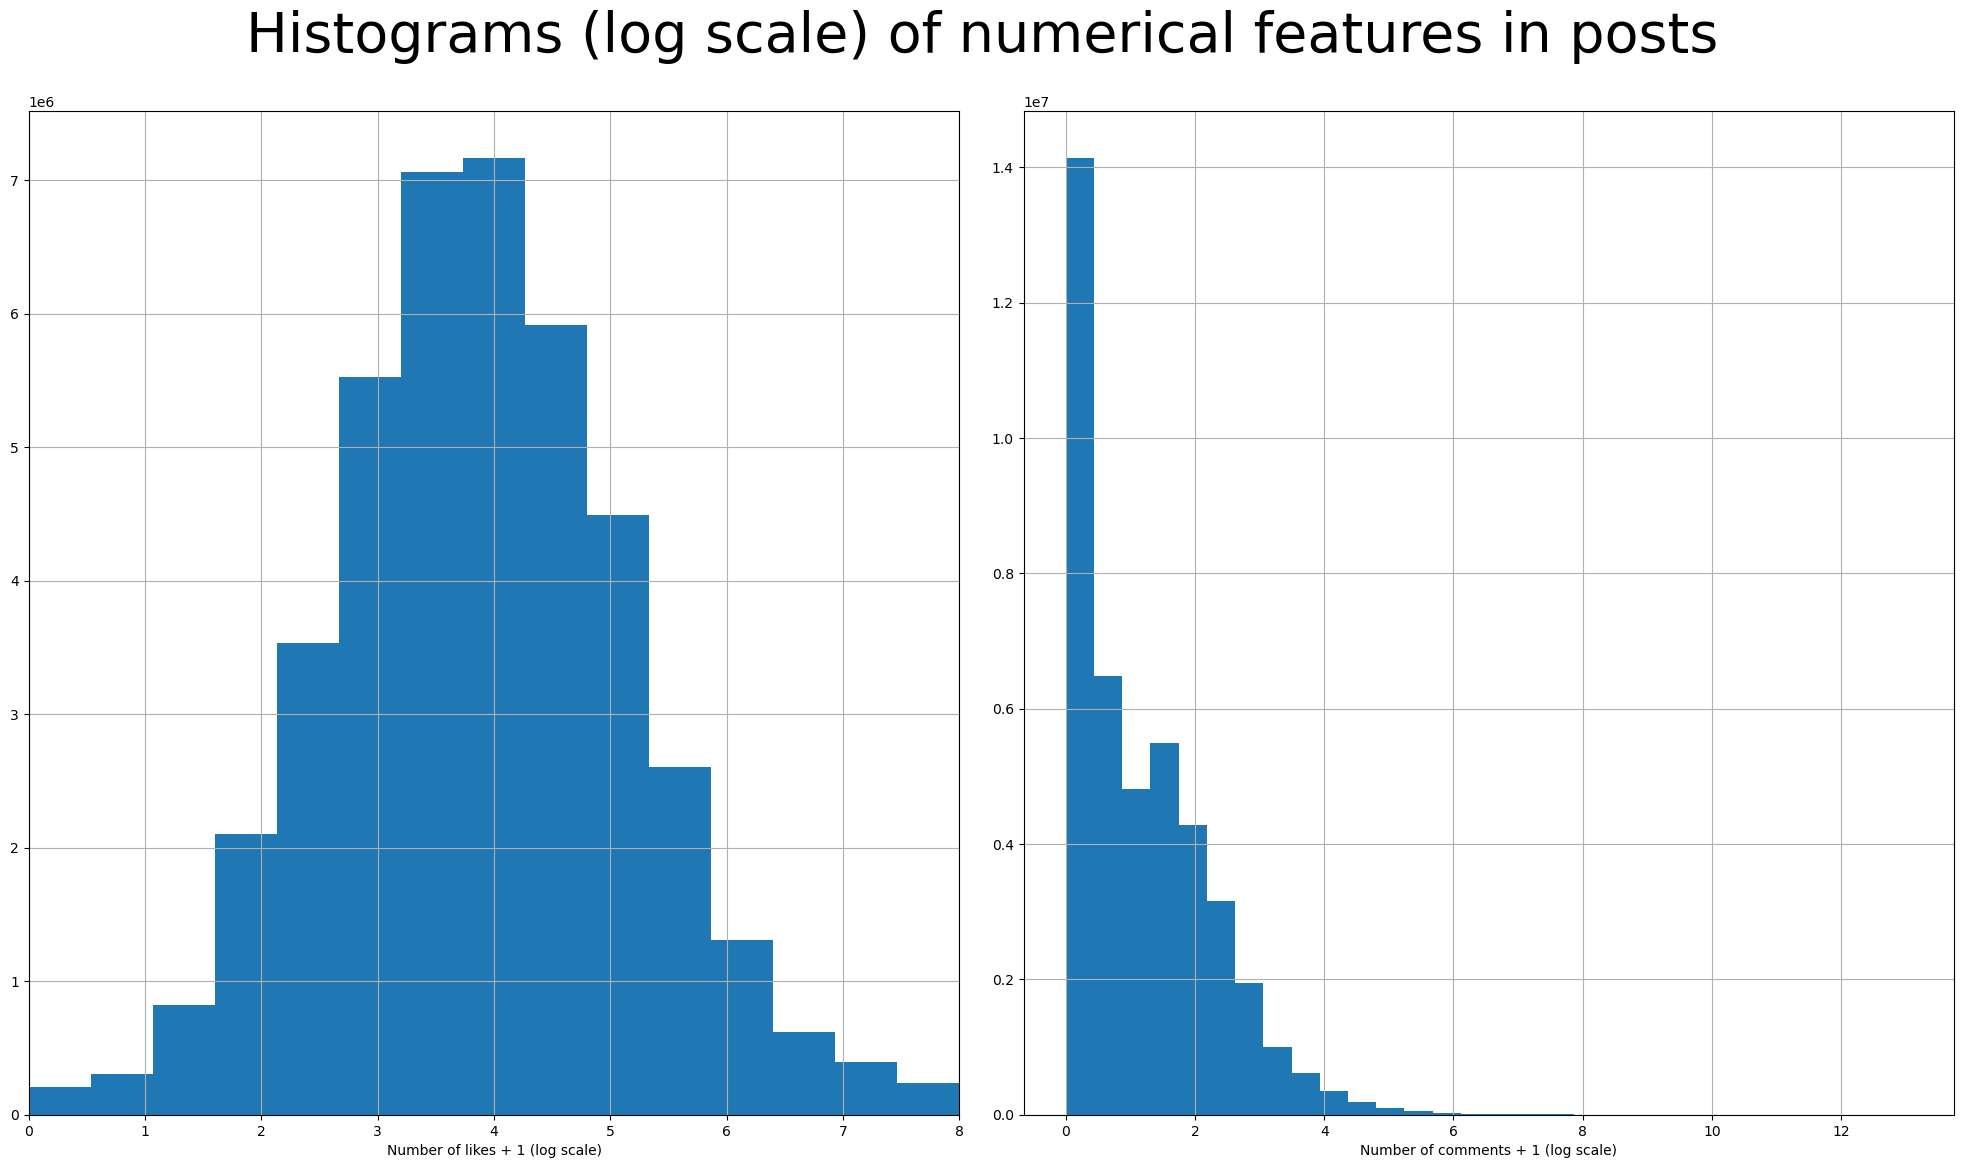

In [85]:
plt.figure(figsize=(20, 12))
ax = plt.subplot(1, 2, 1)
(posts["numbr_likes"]+1).apply(np.log).hist(ax = ax, bins = 30)
ax.set_xlabel("Number of likes + 1 (log scale)")
ax.set_xlim((0, 8))
ax = plt.subplot(1, 2, 2)
(posts["number_comments"]+1).apply(np.log).hist(ax = ax, bins = 30)
ax.set_xlabel("Number of comments + 1 (log scale)")
plt.suptitle("Histograms (log scale) of numerical features in posts", fontsize = 40)
plt.tight_layout(pad = 2)
plt.show()

 It seems that the distribution of likes is approximately log-normal, i.e. the logarithm of the number of likes is normally distributed. A way to test this would be a quantile-quantile plot. Let's plot that.

From the plot, we can see that it definitely seems log-normal. The quantiles of the (standardized) sample distribution of the log number of likes almost perfectly match the ones of a standard normal.

We can also check that numerically with a shapiro test.


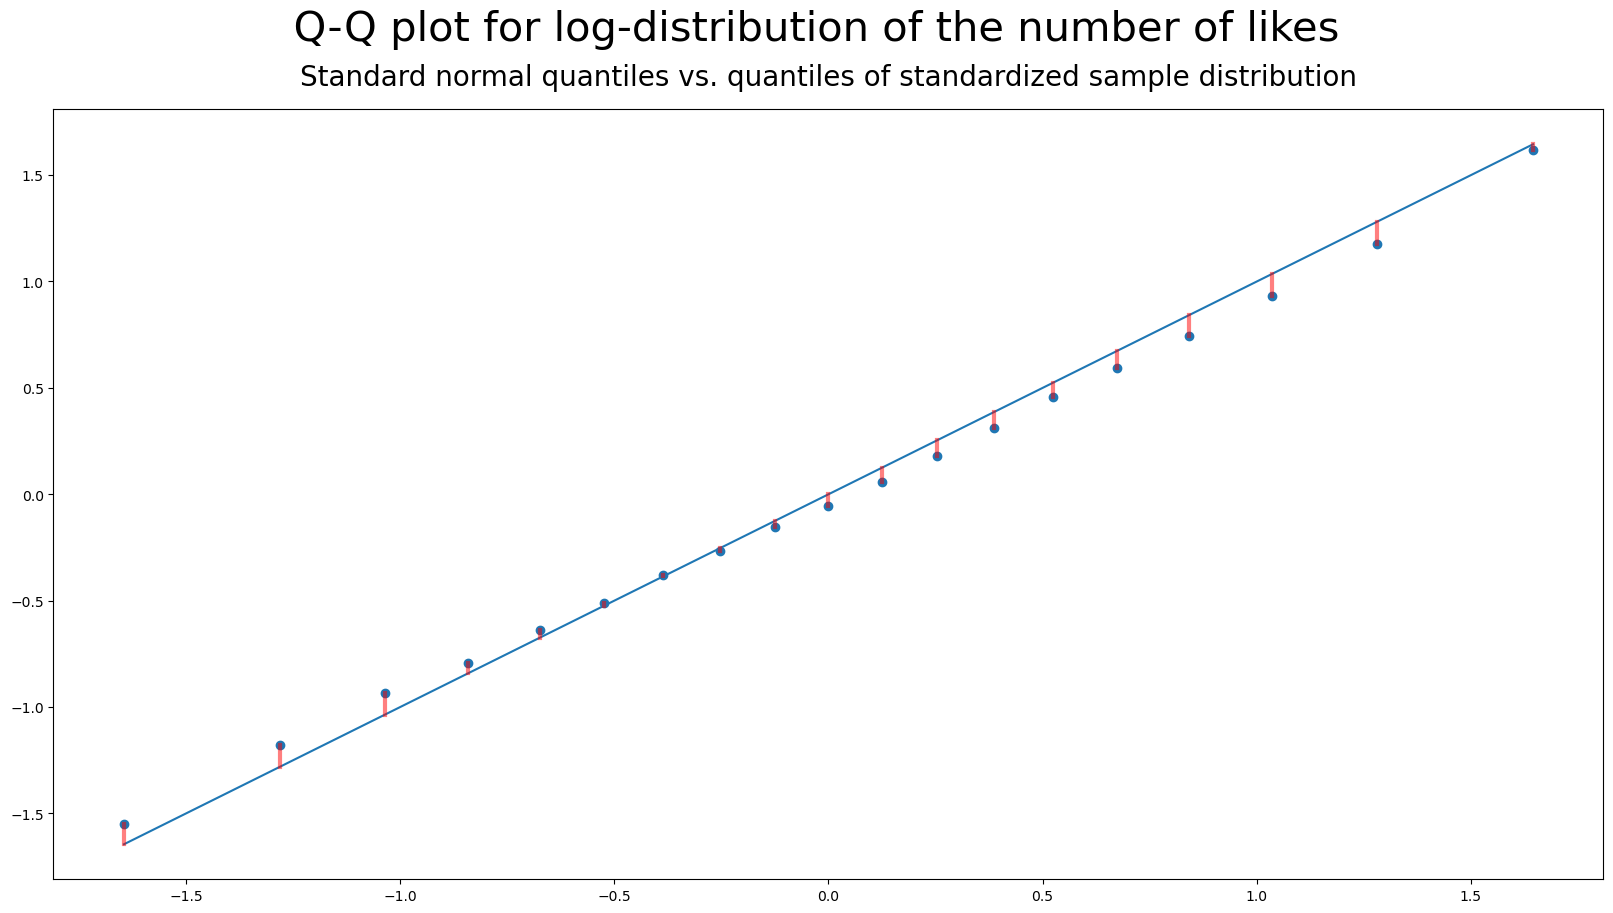

In [20]:
quantiles_stdnorm = [stats.norm.ppf(x) for x in np.arange(0.05, 0.96, 0.05)]

log_transformed_likes = (posts["numbr_likes"]+1).apply(np.log)
sample_quantiles_likes = ((log_transformed_likes-log_transformed_likes.mean())/log_transformed_likes.std()).quantile(np.arange(0.05, 0.96, 0.05))


plt.figure(figsize=(20, 10))
plt.suptitle("  Q-Q plot for log-distribution of the number of likes", fontsize = 30)
plt.title("Standard normal quantiles vs. quantiles of standardized sample distribution", fontsize = 20, y = 1.02)
ax = plt.gca()
ax.plot(quantiles_stdnorm, quantiles_stdnorm)
ax.scatter(quantiles_stdnorm, sample_quantiles_likes)
for standard, sample in zip(quantiles_stdnorm, sample_quantiles_likes):
    ax.plot([standard, standard], [standard, sample], c = "red", alpha = 0.5, linewidth = 3)
plt.show()

 At this point, in this preliminary EDA, a cool stuff that we can do is plotting the mean number of posts per weekday. We can do that quite easily by counting the observations using the weekday as _grouping key_ and then normalizing the count with the number of weeks in the dataset.

As one could expect, the weekend sees the number of posts skyrocketing (less working hours, more trips/holidays, stronger presence of the users online).

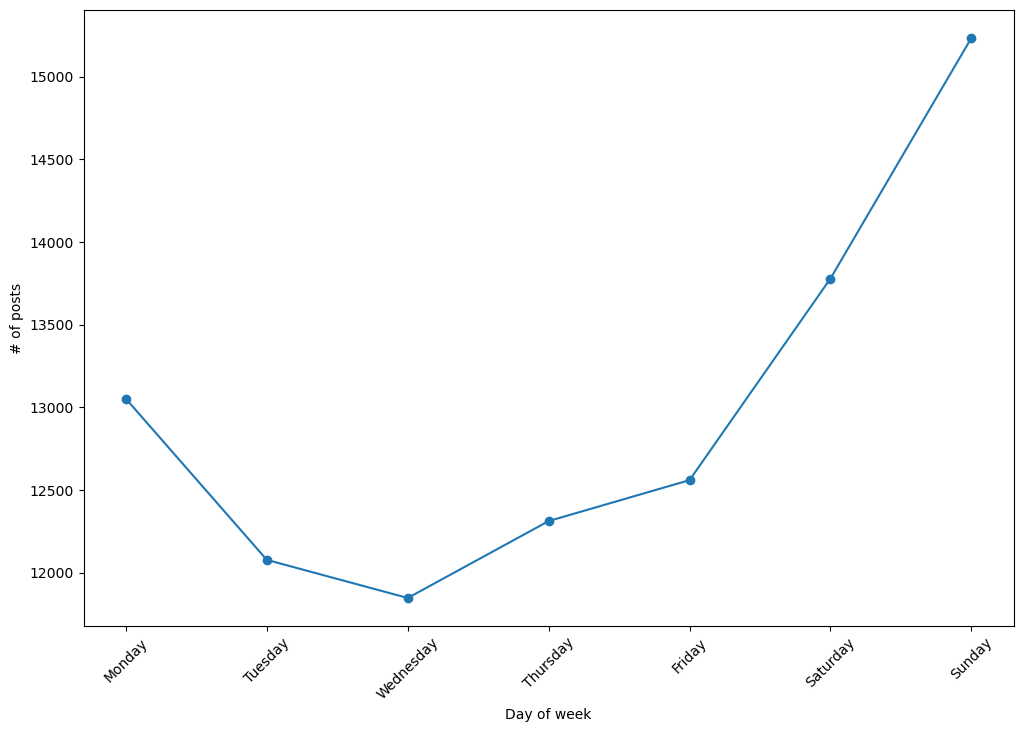

In [16]:
plt.figure(figsize = (12, 8))
number_of_weeks = len(posts["cts"].dt.isocalendar().iloc[:, 0:2].drop_duplicates())
grouped_dayweek_post = posts.groupby(posts["cts"].dt.dayofweek)
week_list = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
count_week = grouped_dayweek_post["sid"].count().set_axis(week_list)
# This normalizes the number of posts giving us the mean number post for each day (across the years)
count_week /= number_of_weeks
count_week.plot(marker="o")
plt.xlabel("Day of week")
plt.ylabel("# of posts")
plt.xticks(rotation=45)
plt.show()

### Features of the _profiles_ dataset
<a id="rq1.2"></a>

 Again, as we did before, let's recap the columns in the table:
 - _sid_ is the key which is used as reference for the foreign key in _posts_
 - profile_id is another id (the Instagram one).
 - profile_name nomen omen.
 - _firstname_lastname_ nomen omen.
 - _description_ is the description of the profile. Looking at the actual strings, it is the "bio" of the profile.
 - _following_ is the number of accounts followed by the users.
 - _followers_ is the number of accounts which follow the user.
 - _n_posts_ is the number of posts published by the user.
 - _url_ is the URL highlighted in the profile under the description/bio.
 - _cts_ is the timestamp for the time when the data of the profile was scraped.
 - _is_business_account_ is a boolean to check if the profile is a business account or not.

In [21]:
print(profiles.columns.values)

['sid' 'profile_id' 'profile_name' 'firstname_lastname' 'description'
 'following' 'followers' 'n_posts' 'url' 'cts' 'is_business_account']


The only numerical columns here are _following_, _followers_ and _n_posts_. We look at their distribution by printing summary statistics and drawing some boxplots (excluding the outliers) and histograms.

Especially for what concerns the followers, what we see is basically the quintessence of what we explained in the [previous point](#graph_theory_pref) of this question. However, since [RQ8](#rq8) specifically deals with the followers' distribution, we will not go in depth with that now.

Let's jump to the number of posts for the moment. The distribution for the number of posts seems far less distorted than the one of followers (or than the one of likes), and this is because the number of posts is not something **strictly** related to the popularity of the user, which is in turn modelled by a preferential attachment process. Again, this is intuitive: a user may enjoy interacting with its relatively small subset of followers and publish a lot, maybe at the same or at a similar rate of an influencer.

This is also highlighted, as can be seen from one of the histograms below, by the fact that the number of posts does not seem to be log-normally distributed, since the log-distribution is definitely left-tailed.

The distortion (anyway strongly present) highlighted by skewness and kurtosis can be easily explained (at least in part) by the fact that a social network is full of _zombie accounts_: bots, inactive users and people subscribing just to follow other people.

In [24]:
# Basic summary statistics for profiles
# print(profiles.describe().iloc[1:, 2:].drop("min", axis = 0).to_markdown(), end = "\n\n")

print("Skewness for # of posts distro: {}".format(round(profiles["n_posts"].skew(), 2)))
print("Excess kurtosis for # of posts distro: {}".format(round(profiles["n_posts"].kurtosis(), 2)))

Skewness for # of posts distro: 21.8
Excess kurtosis for # of posts distro: 1510.84


|      |      following |        followers |    n_posts |
|:-----|---------------:|-----------------:|-----------:|
| mean | 1405.64        |   4739.9         |    409.541 |
| std  | 8113.47        | 193909           |   1041.94  |
| 25%  |  356           |    159           |     22     |
| 50%  |  754           |    406           |    120     |
| 75%  | 1573           |    974           |    420     |
| max  |    4.19108e+06 |      2.85458e+08 | 183730     |


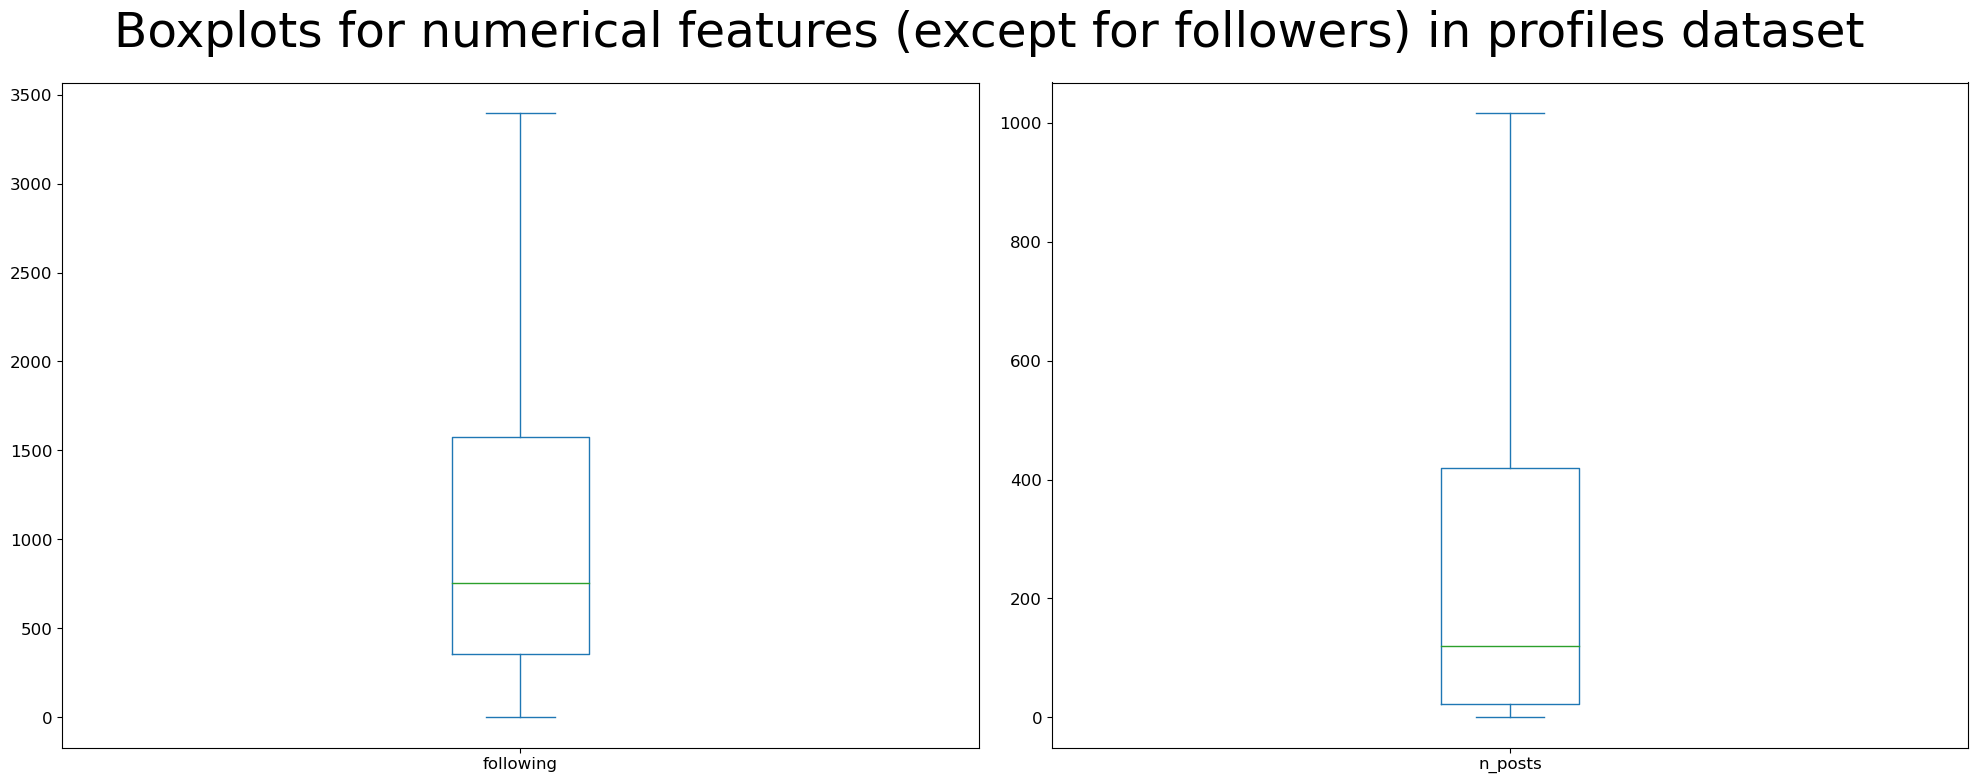

In [28]:
# Boxplots of numerical features in profiles (-followers)
plt.figure(figsize=(20, 8))
ax = plt.subplot(1, 2, 1)
profiles[["following"]].plot.box(showfliers=False, fontsize = "large", ax = ax)
ax = plt.subplot(1, 2, 2)
profiles[["n_posts"]].plot.box(showfliers=False, fontsize = "large", ax = ax)
plt.suptitle("Boxplots for numerical features (except for followers) in profiles dataset", fontsize = 35)
plt.tight_layout(pad = 1.5)
plt.show()

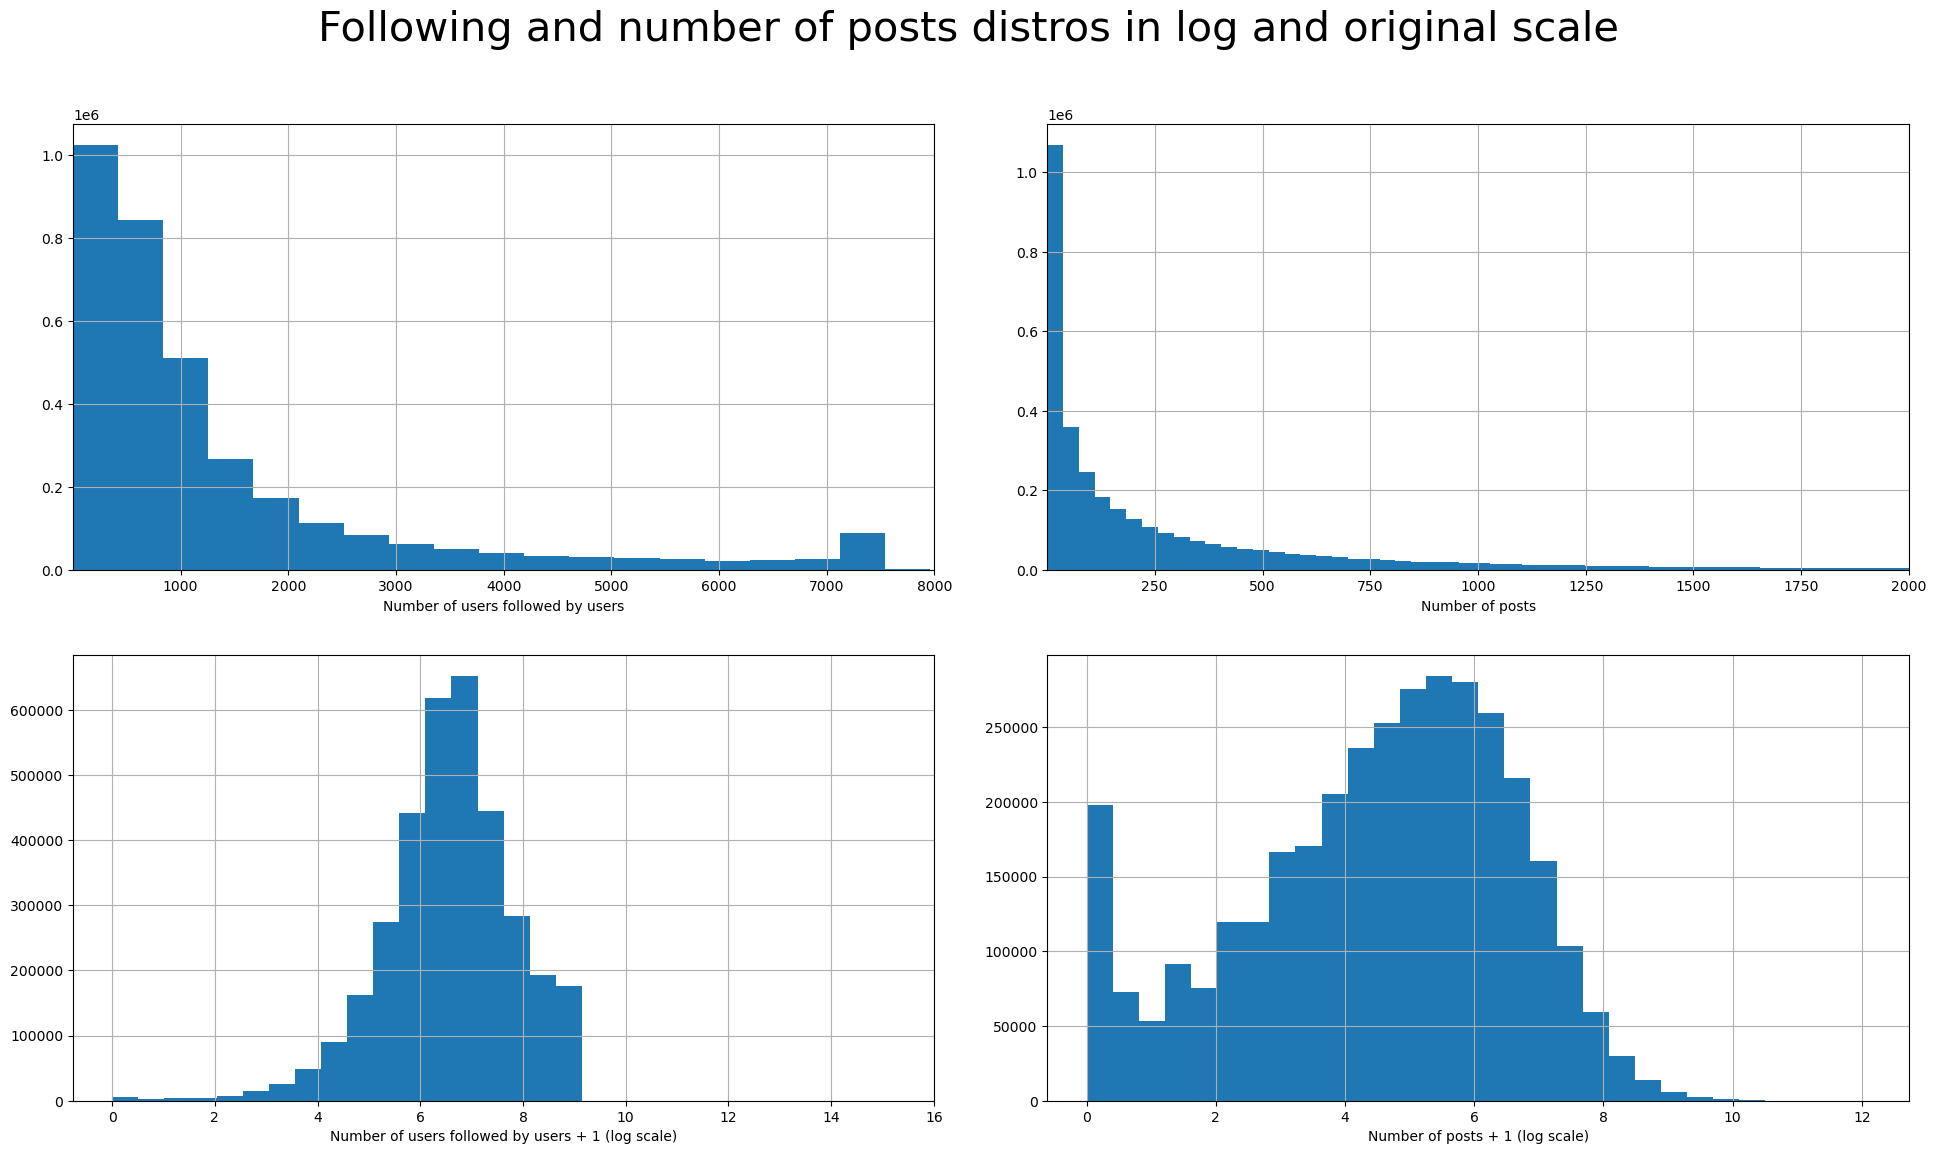

In [75]:
# Histograms

plt.figure(figsize=(20, 12))
ax = plt.subplot(2, 2, 1)
profiles.following.hist(ax = ax, bins = 10000)
ax.set_xlim((1, 8000))
ax.set_xlabel("Number of users followed by users")
ax = plt.subplot(2, 2, 2)
profiles.n_posts.hist(ax = ax, bins = 5000)
ax.set_xlim((1, 2000))
ax.set_xlabel("Number of posts")
ax = plt.subplot(2, 2, 3)
(profiles["following"]+1).apply(np.log).hist(ax = ax, bins = 30)
ax.set_xlabel("Number of users followed by users + 1 (log scale)")
ax = plt.subplot(2, 2, 4)
(profiles["n_posts"]+1).apply(np.log).hist(ax = ax, bins = 30)
ax.set_xlabel("Number of posts + 1 (log scale)")
plt.suptitle("Following and number of posts distros in log and original scale", fontsize = 30)
plt.tight_layout(pad = 3)
plt.show()

### Plotting the _locations_ dataset
<a id="rq1.3"></a>

The _locations_ dataset is purely geographical data, and probably the best way to plot it is by using a world map.

Before continuing, we check the presence of missing values for what concerns latitude and/or longitude. The 0.6% of the locations does not have geographic coordinates, this means that we have a lot of data for the plot!

Notice also that the original dataset has latitude in place of the longitude, and viceversa, so we need to swap the two, [as I wrote on Kaggle](https://www.kaggle.com/datasets/shmalex/instagram-dataset/discussion/361643) for the other colleagues to notice.

The naive way would be to just plot each of the locations as a point in a world map. Spoiler: this results in a textbook case of overplotting. We cannot understand anything because the number of points scattered is too high.

In [81]:
assert locations.lng.isna().sum() == locations.lat.isna().sum()
print(f"Missing coordinates (percentage): {round(locations.lng.isna().sum()/len(locations), 5)}")

locations["lat"], locations["lng"] = locations["lng"], locations["lat"]

Missing coordinates (percentage): 0.00603


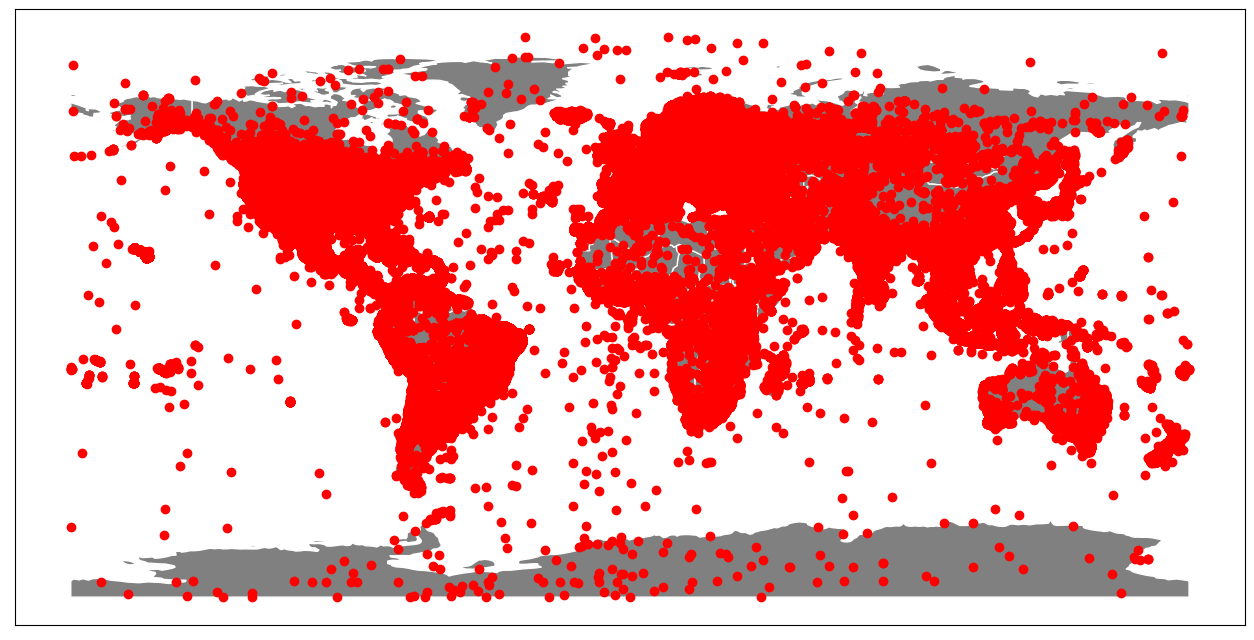

In [82]:
plt.figure(figsize=(17, 8))
ax = plt.gca()
world = geopd.read_file(geopd.datasets.get_path("naturalearth_lowres"))
world.plot(color="gray", edgecolor = "white", ax = ax)
plt.sca(ax)
plt.scatter(locations["lng"], locations["lat"], color = "red")
plt.xticks([])
plt.yticks([])
plt.show()

How can we solve this? The simplest and probably the most effective way is clustering the data and plotting just the centroids, keeping the information concerning the size of each cluster. There are different ways to do clustering, the simplest is probably **K-means**, clustering the points in the $\mathbb{R}^2$ space given by latitude and longitude.

To do this, we use scikit-learn. The hyperparameters which are set are, more or less arbitrarily:
- 100 is set as the number of initialized centroids and thus of the resulting number of clusters.
- 10 is set as the number of different initializations of the centroids (the best one in terms of the final intra-cluster variance is chosen as the best).
- 50 is set as the maximum number of iterations for the algorithm.
- Tolerance is set to 0. This is the (relative) tolerance with respect to the Frobenius norm of the difference in the centroids between two consecutive iterations. This hyperparameter set to 0 means that the algorithm needs to find a strict convergence in order to stop before the maximum number of iterations.


At first glance, the plot (the position and the size of the points/the centroids) allows use to notice that most of the locations in the _locations_ table are concentrated in the United States and in Europe, with some relevant clusters also in South America, western Russia (which indeed accounts for about 75% of Russia's population), India, Indonesia, Japan, Thailand and southern Australia (around Melbourne and Sydney). I hope that I did not make mistakes geography-wise...

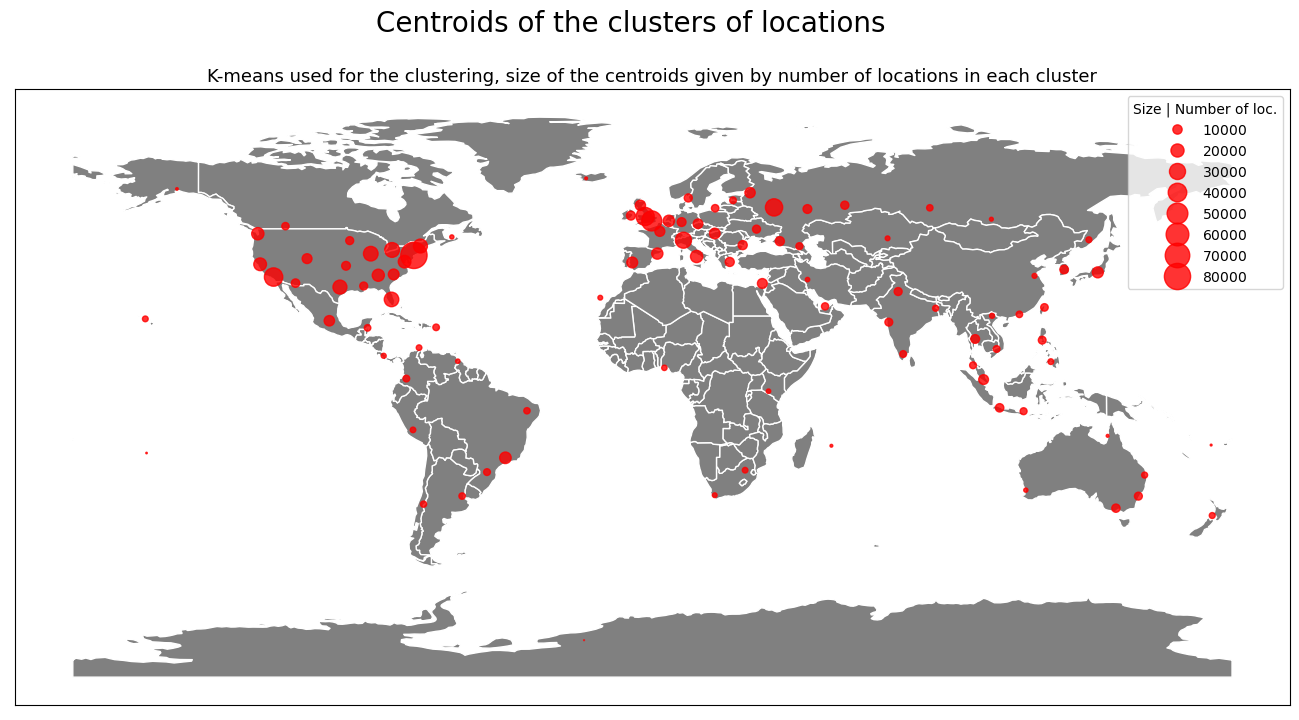

In [87]:
# K-means clustering with scikit
kmeans_fit = clustering.KMeans(n_clusters=100, verbose=0, n_init=10, random_state=123, max_iter=50, tol = 0).fit(locations[["lng", "lat"]].dropna())

# Get centroids, get number of observations for each cluster (will be used as size of the point)
centroids = kmeans_fit.cluster_centers_
_ , weights = np.unique(kmeans_fit.labels_, return_counts=True)
geocluster_df = pd.DataFrame(centroids, columns = [["lng", "lat"]])
standardization_factor_positions = np.std(weights)
geocluster_df["weights"] = weights/standardization_factor_positions*50

# Plot
plt.figure(figsize=(17, 8))
ax = plt.gca()
world.plot(color="gray", edgecolor = "white", ax = ax)
plt.sca(ax)
scatter_plot = plt.scatter(geocluster_df.iloc[:, 0], geocluster_df.iloc[:, 1], color = "red", alpha = 0.8, s = geocluster_df["weights"])
plt.xticks([])
plt.yticks([])

handles, labels = scatter_plot.legend_elements(prop="sizes", alpha=0.8, color="red", func = lambda x: x*standardization_factor_positions/50)

plt.legend(handles, labels, title = "Size | Number of loc.")
plt.suptitle("Centroids of the clusters of locations", fontsize = 20)
plt.title("K-means used for the clustering, size of the centroids given by number of locations in each cluster", fontsize = 13)
plt.show()